In [1]:
# !pip install -r requirements.txt

In [2]:
import torch
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from collections import namedtuple
import copy
import os

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1. Image Processing

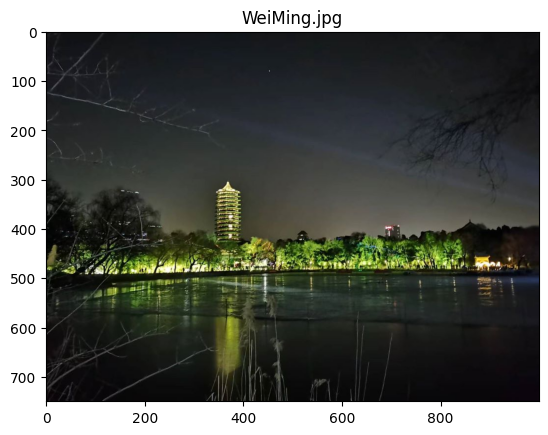

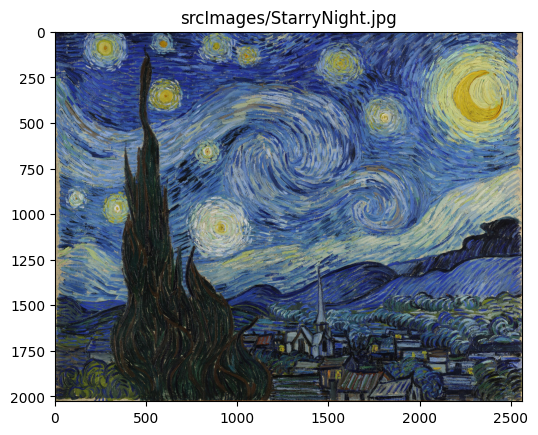

In [4]:
def imgload(path):
    img = Image.open(path)
    plt.imshow(img)
    plt.title(path.split("\\")[-1])
    plt.show()
    return img

content_img = imgload("srcImages\WeiMing.jpg")
style_img = imgload("srcImages/StarryNight.jpg")

img_shape = (content_img.size[1] // 2, content_img.size[0] // 2)

In [5]:
rgb_mean = torch.tensor([123.675, 116.28, 103.53])
rgb_std = torch.tensor([1, 1, 1])


def preprocess(img, image_shape) -> torch.Tensor:
    transform = transforms.Compose(
        [
            transforms.Resize(image_shape),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.mul(255)),
            transforms.Normalize(mean=rgb_mean, std=rgb_std),
        ]
    )
    return transform(img).to(device).unsqueeze(0)  # (1, C, H, W)


def postprocess(img):
    img = img[0].to("cpu").detach()  # cpu
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 255)
    return img.permute(2, 0, 1) / 255


content_img_t = preprocess(content_img, img_shape)
style_img_t = preprocess(style_img, img_shape)

In [6]:
init = "content"
if init == "random":
    gen_img = np.random.normal(loc=0, scale=255 / 2, size=content_img_t.shape).astype(
        np.float32
    )
    gen_img_t = torch.from_numpy(gen_img).to(device)
elif init == "content":
    gen_img_t = content_img_t.clone()
elif init == "style":
    gen_img_t = style_img_t.clone()
else:
    raise ValueError(f"init method \"{init}\" is not supported.")
gen_img_t.requires_grad = True

# 2. Create Model

In [7]:
class Vgg19(torch.nn.Module):
    """
    style: 'conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1'
    content: 'conv4_2'
    """

    def __init__(self, requires_grad=False, use_relu=True):
        super().__init__()
        if os.path.exists("./vgg19/vgg19-dcbb9e9d.pth"):
            vgg19_model = models.vgg19(weights=None)
            vgg19_model.load_state_dict(torch.load("./vgg19/vgg19-dcbb9e9d.pth"))
            pretrained_vgg19 = vgg19_model.features
        else:
            pretrained_vgg19 = models.vgg19(
                weights=models.VGG19_Weights.DEFAULT
            ).features

        if use_relu:  # use relu or as in original paper conv layers
            self.layer_names = [
                "relu1_1",
                "relu2_1",
                "relu3_1",
                "relu4_1",
                "conv4_2",
                "relu5_1",
            ]
            self.offset = 1
        else:
            self.layer_names = [
                "conv1_1",
                "conv2_1",
                "conv3_1",
                "conv4_1",
                "conv4_2",
                "conv5_1",
            ]
            self.offset = 0
        self.content_index = 4  # conv4_2

        # all layers except conv4_2
        self.style_index = [0, 1, 2, 3, 5]

        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        self.slice6 = torch.nn.Sequential()
        
        for x in range(1 + self.offset):
            self.slice1.add_module(str(x), pretrained_vgg19[x])
        for x in range(1 + self.offset, 6 + self.offset):
            self.slice2.add_module(str(x), pretrained_vgg19[x])
        for x in range(6 + self.offset, 11 + self.offset):
            self.slice3.add_module(str(x), pretrained_vgg19[x])
        for x in range(11 + self.offset, 20 + self.offset):
            self.slice4.add_module(str(x), pretrained_vgg19[x])
        for x in range(20 + self.offset, 22):
            self.slice5.add_module(str(x), pretrained_vgg19[x])
        for x in range(22, 29 + self.offset):
            self.slice6.add_module(str(x), pretrained_vgg19[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.slice1(x)
        layer1_1 = x
        x = self.slice2(x)
        layer2_1 = x
        x = self.slice3(x)
        layer3_1 = x
        x = self.slice4(x)
        layer4_1 = x
        x = self.slice5(x)
        conv4_2 = x
        x = self.slice6(x)
        layer5_1 = x
        vgg_outputs = namedtuple("VggOutputs", self.layer_names)
        out = vgg_outputs(layer1_1, layer2_1, layer3_1, layer4_1, conv4_2, layer5_1)
        return out

In [8]:
model = Vgg19(requires_grad=False, use_relu=True)
content_index = model.content_index # 4
style_indices = model.style_index # 0, 1, 2, 3, 5

layer_names = model.layer_names

model.to(device).eval()

Vgg19(
  (slice1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (slice2): Sequential(
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
  )
  (slice3): Sequential(
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
  )
  (slice4): Sequential(
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): R

# 3. Loss

In [9]:
def gram_matrix(x, should_normalize=True):
    # batch
    (b, c, h, w) = x.size()
    features = x.view(b, c, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t)
    if should_normalize:
        gram /= c * h * w
    return gram


def total_variation(y):
    return torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + torch.sum(
        torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])
    )

In [10]:
content_feature = model(content_img_t)
style_feature = model(style_img_t)


def get_content_rep(img_feature):
    return img_feature[content_index].squeeze(axis=0)  # (512, h/8, w/8)


def get_style_rep(img_feature):
    return [gram_matrix(x) for cnt, x in enumerate(img_feature) if cnt in style_indices]


target_content_representation = get_content_rep(content_feature)
target_style_representation = get_style_rep(style_feature)

In [11]:
content_weight, style_weight, tv_weight = 1e5, 5e4, 1

def get_loss(
    vggmodel,
    generating_img_tensor,
    target_content_rep,
    target_style_rep,
):
    
    gen_feature = vggmodel(generating_img_tensor)
    gen_content_rep = get_content_rep(gen_feature)
    gen_style_rep = get_style_rep(gen_feature)

    content_loss = torch.nn.MSELoss(reduction="mean")(
        target_content_rep, gen_content_rep
    )

    style_loss = 0.0
    for gram_gt, gram_hat in zip(target_style_rep, gen_style_rep):
        style_loss += torch.nn.MSELoss(reduction="sum")(gram_gt[0], gram_hat[0])
    style_loss /= len(target_style_representation)

    tv_loss = total_variation(generating_img_tensor)
    
    total_loss = content_weight * content_loss + style_weight * style_loss + tv_weight * tv_loss
    
    return total_loss, content_loss, style_loss, tv_loss

In [12]:
gen_img_t

tensor([[[[-104.6750, -104.6750,  -93.6750,  ..., -105.6750, -104.6750,
           -103.6750],
          [-103.6750, -100.6750,  -91.6750,  ..., -106.6750, -105.6750,
           -104.6750],
          [ -96.6750,  -93.6750,  -95.6750,  ..., -107.6750, -106.6750,
           -104.6750],
          ...,
          [-101.6750, -110.6750, -108.6750,  ..., -111.6750, -110.6750,
           -110.6750],
          [-104.6750, -109.6750, -100.6750,  ..., -111.6750, -110.6750,
           -110.6750],
          [-108.6750, -106.6750,  -96.6750,  ..., -111.6750, -110.6750,
           -110.6750]],

         [[ -97.2800,  -97.2800,  -86.2800,  ...,  -98.2800,  -97.2800,
            -96.2800],
          [ -96.2800,  -93.2800,  -84.2800,  ...,  -99.2800,  -98.2800,
            -97.2800],
          [ -89.2800,  -86.2800,  -88.2800,  ..., -100.2800,  -99.2800,
            -97.2800],
          ...,
          [-100.2800, -109.2800, -107.2800,  ..., -111.2800, -110.2800,
           -110.2800],
          [-103.28

In [13]:
optimizer = optim.Adam((gen_img_t,), lr=1)

iterations = 3000

for it in range(iterations):
    total_loss, content_loss, style_loss, tv_loss = get_loss(
        vggmodel=model,
        generating_img_tensor=gen_img_t,
        target_content_rep=target_content_representation,
        target_style_rep=target_style_representation,
    )
    total_loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    if it % 50 == 0 or it == iterations - 1:
        with torch.no_grad():
            print(
                f"Adam | iteration: {it:04}, total loss={total_loss.item()}, content_loss={content_weight * content_loss.item()}, style loss={style_weight * style_loss.item()}, tv loss={tv_weight * tv_loss.item()}"
            )
            if it % 200 == 0 or it == iterations - 1:
                torchvision.utils.save_image(postprocess(gen_img_t), f"outputs/iter{it:04}.jpg")

Adam | iteration: 0000, total loss=733553688576.0, content_loss=0.0, style loss=733551540000.0, tv loss=2158968.0
Adam | iteration: 0050, total loss=53756461056.0, content_loss=753854931.640625, style loss=52997111250.0, tv loss=5492335.0
Adam | iteration: 0100, total loss=27413106688.0, content_loss=834386035.15625, style loss=26572790625.0, tv loss=5931874.0
Adam | iteration: 0150, total loss=18434017280.0, content_loss=864043847.65625, style loss=17563740000.0, tv loss=6234409.5
Adam | iteration: 0200, total loss=13780444160.0, content_loss=880408593.75, style loss=12893559375.0, tv loss=6475701.5
Adam | iteration: 0250, total loss=10854197248.0, content_loss=889215917.96875, style loss=9958304062.5, tv loss=6677688.5
Adam | iteration: 0300, total loss=8852855808.0, content_loss=895870410.15625, style loss=7950133125.0, tv loss=6852466.0
Adam | iteration: 0350, total loss=7423497728.0, content_loss=900302636.71875, style loss=6516192656.25, tv loss=7002165.5
Adam | iteration: 0400, 